In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import pandas

In [2]:
precision = np.double

def gen_plane_point(min, max):
    a = precision(np.random.uniform(min, max))
    b = precision(np.random.uniform(min, max))
    return (a, b)

def gen_plane_points(n, min, max):
    return [gen_plane_point(min, max) for _ in range(n)]


def gen_circle_point(r, s):
    fi = np.random.uniform(0.0, 2*math.pi)
    x = precision(r*math.cos(fi)) + s[0]
    y = precision(r*math.sin(fi)) + s[1]
    return (x, y)

def gen_circle_points(n, r, s):
    return [gen_circle_point(r, s) for _ in range(n)]
    
def gen_rect_point(min_x, max_x, min_y, max_y):
    a = np.random.uniform(min_x, max_x)
    b = np.random.uniform(min_y, max_y)
    rand = np.random.randint(0, 4)
    if (rand == 0):
        a = max_x
    elif (rand == 1):
        a = min_x
    elif (rand == 2):
        b = max_y
    else:
        b = min_y
    return (precision(a), precision(b))

def gen_rect_points(n, a, b, c, d):
    return [gen_rect_point(b[0], d[0], b[1], d[1]) for _ in range(n)]


def gen_rect_x_point(min, max):
    a = precision(np.random.uniform(min, max))
    return (precision(0), a)

def gen_rect_y_point(min, max):
    a = precision(np.random.uniform(min, max))
    return (a, precision(0))

def gen_rect_diag_x_point(min, max):
    a = precision(np.random.uniform(min, max))
    return (a, a)

def gen_rect_diag_y_point(min, max):
    a = precision(np.random.uniform(min, max))
    return ((max-min)-a, a)

def gen_rect_diag_xy_points(a, b, c, d, diag_n, rect_n):
    diag_x = [gen_rect_diag_x_point(a[0], c[0]) for _ in range(diag_n)]
    diag_y = [gen_rect_diag_y_point(a[1], c[1]) for _ in range(diag_n)]
    rect_x = [gen_rect_x_point(a[0], c[0]) for _ in range(rect_n)]
    rect_y = [gen_rect_y_point(a[1], c[1]) for _ in range(rect_n)]
    i = 0
    points = []
    for x in diag_x:
        points.insert(i, x)
        i += 1
    for x in diag_y:
        points.insert(i, x)
        i += 1
    for x in rect_x:
        points.insert(i, x)
        i += 1
    for x in rect_y:
        points.insert(i, x)
        i += 1
        
    points.append(a)
    points.append(b)
    points.append(c)
    points.append(d)
    return points

In [3]:
a1,b1,c1,d1 = ((-10, 10), (-10, -10), (10,-10),(10,10))
a2,b2,c2,d2 = ((0, 0), (10, 0), (10, 10), (0, 10))
s = (0, 0)

def gen_sets(n):
    sets = []
    sets.append(gen_plane_points(n, -100, 100))
    sets.append(gen_circle_points(n, 10, s))
    sets.append(gen_rect_points(n, a1, b1, c1, d1))
    sets.append(gen_rect_diag_xy_points(a1, b1, c1, d1, int(n/4), int(n/4)))
    return sets
        
plane_points = gen_plane_points(100, -100, 100)
circle_points = gen_circle_points(100, 10, s)
rect_points = gen_rect_points(100, a1, b1, c1, d1)
rect_boost_points = gen_rect_diag_xy_points(a2, b2, c2, d2, 20, 25)
sets = [plane_points, circle_points, rect_points, rect_boost_points]

In [4]:
def plot_set(x, y, size=0.5):
#     plt.figure(figsize=(12,12))
    plt.ylabel('y')
    plt.xlabel('x')
    plt.scatter(x,y, color="magenta", s=size)
    plt.show()

In [5]:
def plot_set_hull(points, hull, size):
    x,y = np.array(points).T
    h_x, h_y = np.array(hull).T
    print("Liczba punktow w otoczce: " + str(len(hull)))
#     plt.figure(figsize=(12,12))
    plt.ylabel('y')
    plt.xlabel('x')
    plt.scatter(x,y, color="magenta", s=size)
    plt.scatter(h_x[1:], h_y[1:], color="blue", s=size*2)
    plt.scatter(h_x[0:1], h_y[0:1], color="red", s=size*2.5)
    plt.fill(h_x, h_y, edgecolor="green", fill=False)
    plt.show()

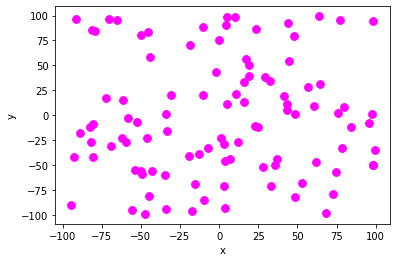

In [6]:
x,y = np.array(sets[0]).T
plot_set(x, y, size=60)

In [7]:
eps = 10e-4

def graham(points):
    def det(p1, p2, p3):
        return (p2[0] - p1[0])*(p3[1] - p1[1]) - (p2[1] - p1[1])*(p3[0] - p1[0])
        
    def slope(p1, p2):
        s = (p1[1]-p2[1])/(p1[0]-p2[0]) if abs(p1[0]-p2[0]) > eps else float('inf')
        return s
      
    # znajdz pierwszy punkt i usun go z puli punktow
    start = min(points, key=lambda p: (p[0], p[1]))
    points_cpy = [x for x in points]
    points_cpy.pop(points_cpy.index(start))
  
    # posortuj ze wzgledu na nachylenie 
    points_cpy.sort(key=lambda p: (slope(p, start), -p[1], p[0]))
      
    # dodawaj punkty posortowane jezeli nie sa wspoliniowe 
    result = [start]
    for p in points_cpy:
        result.append(p)
        while len(result) > 2 and det(result[-3], result[-2], result[-1]) < eps:
            result.pop(-2)
            
    # jezeli dwa ostatnie i startowy sa wspoliniowe to wywal srodkowy        
    if det(result[-2], result[-1], result[0]) < eps:
        result.pop(-1)
        
    return result

In [8]:
sets_names = ["A", "B", "C", "D"]

def graham_times(sets):
    result = {}
    for i in range(4):
        t = time.time()
        graham(sets[i])
        dt = time.time()-t
        result[sets_names[i]] = dt
    return result
        
def graham_time_test():
    result = {}
    for i in range(100, 1001, 100):
        result[i] = graham_times(gen_sets(i))
    return result
pandas.DataFrame(graham_time_test())

,100,200,300,400,500,600,700,800,900,1000
A,0.000428,0.000953,0.001325,0.001929,0.002411,0.002934,0.003211,0.003711,0.004594,0.004867
B,0.000319,0.000739,0.001185,0.001531,0.002000,0.002854,0.003092,0.003433,0.004207,0.004884
C,0.000606,0.000926,0.001325,0.001815,0.002346,0.002969,0.003374,0.003945,0.004753,0.005344
D,0.000470,0.001021,0.001394,0.001836,0.002589,0.002960,0.003463,0.004072,0.004499,0.005198


Eps: 0
Liczba punktow w otoczce: 9


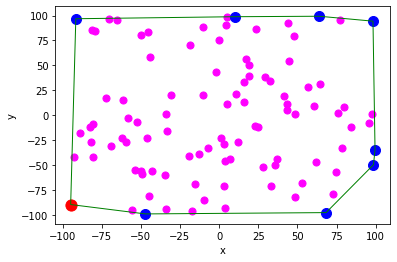

In [9]:
eps = 0
print("Eps: " + str(eps))
plot_set_hull(sets[0], graham(sets[0]), size=50)

In [10]:
def cmp(a):
    if a > eps:
        return 1
    elif a < -eps:
        return -1
    else:
        return 0

def turn(p1, p2, p3):
    return cmp((p2[0]-p1[0])*(p3[1]-p1[1])-(p3[0]-p1[0])*(p2[1]-p1[1]))

def dist(p1, p2):
    return (p2[0]-p1[0])**2 + (p2[1]-p1[1])**2

def next_hull_point(points, p1):
    p2 = p1
    for p3 in points:
        d = turn(p1, p2, p3)
        if d == -1 or d == 0 and dist(p1, p3) > dist(p1, p2):
            p2 = p3
    return p2

def jarvis(points):
    hull = [min(points)]
    for p in hull:
        q = next_hull_point(points, p)
        if q != hull[0]:
            hull.append(q)
        else:
            break
    return hull

In [11]:
sets_names = ["A", "B", "C", "D"]

import pandas

def jarvis_times(sets):
    result = {}
    for i in range(4):
        t = time.time()
        jarvis(sets[i])
        dt = time.time()-t
        result[sets_names[i]] = dt
    return result
        
def jarvis_time_test():
    result = {}
    for i in range(100, 1001, 100):
        result[i] = jarvis_times(gen_sets(i))
    return result

pandas.DataFrame(jarvis_time_test())

,100,200,300,400,500,600,700,800,900,1000
A,0.001798,0.003935,0.007609,0.010299,0.014423,0.010900,0.018008,0.021131,0.025406,0.022691
B,0.014938,0.058475,0.136843,0.227320,0.361566,0.519009,0.697630,0.895649,1.154457,1.417817
C,0.001456,0.003036,0.004259,0.005664,0.006891,0.008651,0.009685,0.010951,0.012668,0.014917
D,0.001629,0.003330,0.004180,0.005155,0.006809,0.008288,0.009158,0.010604,0.013114,0.014787


Eps: 0
Liczba punktow w otoczce: 4


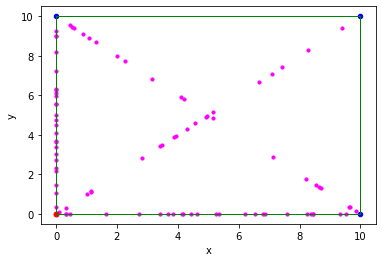

In [12]:
eps = 0
print("Eps: " + str(eps))
plot_set_hull(sets[3], jarvis(sets[3]), size=10)

In [22]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()
        
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

    
# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = True)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

In [23]:
eps = 10e-10
def graham_scenes(points):
    scenes = []
    result = []
    # znajdz pierwszy punkt i usun go z puli punktow
    start = min(points, key=lambda p: (p[0], p[1]))
    points_cpy = [x for x in points]
    points_cpy.pop(points_cpy.index(start))
    
    # nachylenie   
    def slope(p1, p2):
        s = (p1[1]-p2[1])/(p1[0]-p2[0]) if abs(p1[0]-p2[0]) > eps else float('inf')
        return s
  
    # posortuj ze wzgledu na nachylenie 
    points_cpy.sort(key=lambda p: (slope(p, start), -p[1], p[0]))
    
    # punkty na scenie
    basic_points = PointsCollection(points, color="blue")
    
    
    def det(p1, p2, p3):
        res = PointsCollection([x for x in result], color="orange")
        lines = LinesCollection([[p1,p3]], color='yellow')
        points = PointsCollection([p1, p2, p3], color='green')
        scenes.append(Scene([basic_points, res, points],[lines]))
        return (p2[0] - p1[0])*(p3[1] - p1[1]) - (p2[1] - p1[1])*(p3[0] - p1[0])
    
    
    # dodawaj punkty posortowane
    result.append(start)
    for p in points_cpy:
        result.append(p)
        
        # dopóki trzy ostatnie punkty są współliniowe to usuwaj środkowy
        while len(result) > 2 and det(result[-3], result[-2], result[-1]) < eps:
            result.pop(-2)
            
    # jezeli dwa ostatnie i startowy sa wspoliniowe to wywal srodkowy        
    if det(result[-2], result[-1], result[0]) < eps:
        result.pop(-1)
    
    res = PointsCollection([x for x in result], color="orange")
    scenes.append(Scene([basic_points, res]))
    
    return scenes

<IPython.core.display.Javascript object>


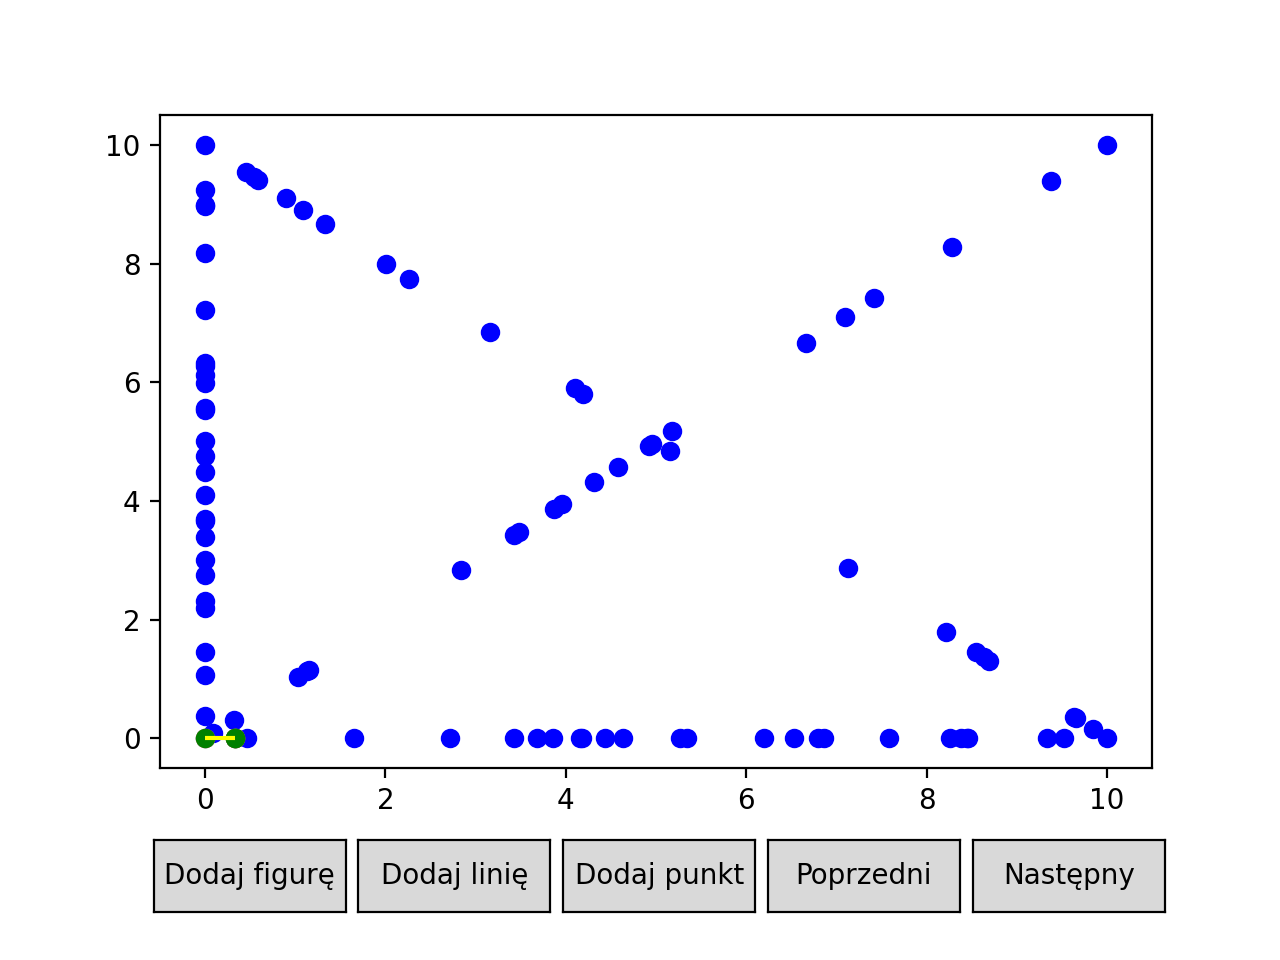

In [24]:
%matplotlib notebook

plot=Plot(scenes = graham_scenes(sets[3]))
plot.draw()

In [35]:
def jarvis_scenes(points):
    scenes = []
    hull = []
    
    basic_points = PointsCollection(points, color='blue')


    
    def cmp(a):
        if a > eps:
            return 1
        elif a < -eps:
            return -1
        else:
            return 0

    def turn(p1, p2, p3):
        return cmp((p2[0]-p1[0])*(p3[1]-p1[1])-(p3[0]-p1[0])*(p2[1]-p1[1]))

    def dist(p1, p2):
        return (p2[0]-p1[0])**2 + (p2[1]-p1[1])**2

    def next_hull_point(points, p1):
        p2 = p1
        for p3 in points:
            d = turn(p1, p2, p3)
            if d == -1 or d == 0 and dist(p1, p3) > dist(p1, p2):
                p2 = p3
        return p2

    hull.append(min(points))
    scenes.append(Scene([basic_points]))
    for p in hull:
        q = next_hull_point(points, p)
        hull_points = PointsCollection([x for x in hull], color="orange")
        q_point = PointsCollection([q], color="green")
        scenes.append(Scene([basic_points, hull_points, q_point]))
        if q != hull[0]:
            hull.append(q)
        else:
            break
            
    hull_points = PointsCollection([x for x in hull], color="orange")
    scenes.append(Scene([basic_points, hull_points]))

    return scenes 

<IPython.core.display.Javascript object>


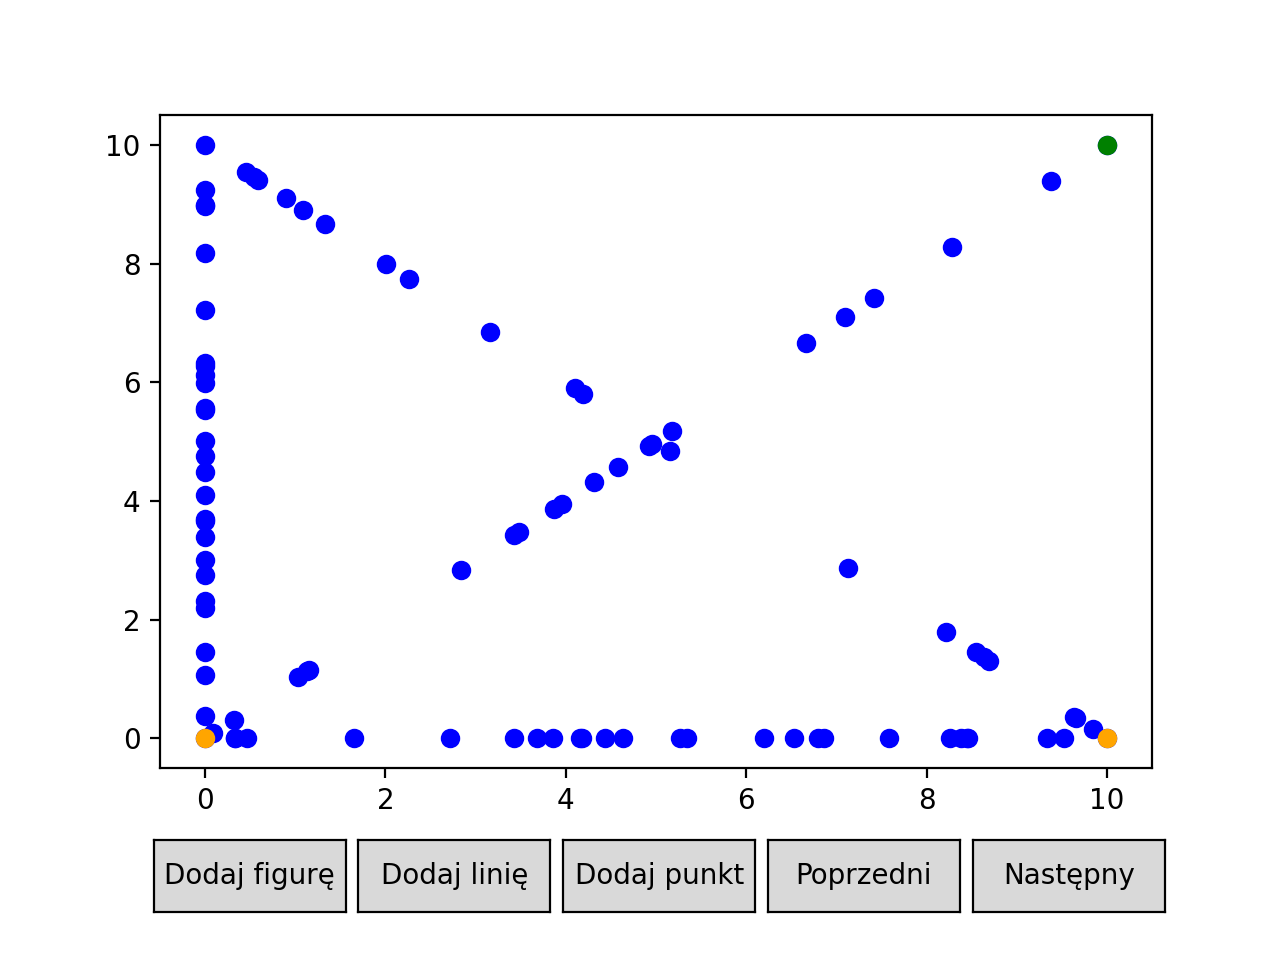

In [36]:
%matplotlib notebook

plot=Plot(scenes = jarvis_scenes(sets[3]))
plot.draw()

In [138]:
with open('somefile.json', 'w') as file:
    file.write(plot.toJson())